In [1]:
# Core libraries
import os
import glob
import gzip
import logging
import warnings

# Scientific computing
import numpy as np
import pandas as pd
import scipy
import h5py

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Bioinformatics
from Bio import SeqIO
import scanpy as sc
import mira

# Setup MIRA output formatting
mira.utils.pretty_sderr()

In [4]:
%config Completer.use_jedi = False

In [5]:
%matplotlib inline

In [ ]:
index_name					Sample Description
SI-NA-A1	AAACGGCG	CCTACCAT	GGCGTTTC	TTGTAAGA	Day0_2
SI-NA-B1	AGGCTACC	CTAGCTGT	GCCAACAA	TATTGGTG	Day3_4
SI-NA-C1	AGACTTTC	CCGAGGCA	GATGCAGT	TTCTACAG	Day5_6

In [ ]:
# day0-2
cellranger-arc count --id=multiome_1st_donor_UPMC_day0_2 \
                       --reference=/media/RAIDArray/JingyuFan/library/cell_ranger/refdata-cellranger-arc-GRCh38-2020-A-2.0.0 \
                       --libraries=/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/libraries.day0_2.csv \
                       --localcores=32 \
                       --localmem=128

# day3-4
cellranger-arc count --id=multiome_1st_donor_UPMC_day3_4 \
                       --reference=/media/RAIDArray/JingyuFan/library/cell_ranger/refdata-cellranger-arc-GRCh38-2020-A-2.0.0 \
                       --libraries=/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/libraries.day3_4.csv \
                       --localcores=32 \
                       --localmem=128

# day5-6
cellranger-arc count --id=multiome_1st_donor_UPMC_day5_6 \
                       --reference=/media/RAIDArray/JingyuFan/library/cell_ranger/refdata-cellranger-arc-GRCh38-2020-A-2.0.0 \
                       --libraries=/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/libraries.day5_6.csv \
                       --localcores=32 \
                       --localmem=128

In [ ]:
# aggregate 3 samples
cellranger-arc aggr --id=multiome_1st_donor_UPMC_aggr \
                  --csv=aggr.csv \
                  --normalize=none \
                  --reference=/media/RAIDArray/JingyuFan/library/cell_ranger/refdata-cellranger-arc-GRCh38-2020-A-2.0.0 \
                    --localcores=64 \
                       --localmem=256

# preprocess

In [35]:
adata_aggregated=sc.read_10x_h5('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/outs/filtered_feature_bc_matrix.h5',
              gex_only=False
                    )



/home/jingyu/miniconda3/envs/mira-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [38]:
adata_aggregated.var_names_make_unique()

In [41]:
adata_aggregated.var['feature_types'].unique()

array(['Gene Expression', 'Peaks'], dtype=object)

In [42]:
adata_aggregated.obs['cell_type_major']=list(map(lambda x: "day0_2" if x.endswith('-1') 
                                                      else "day3_4" if  x.endswith('-2') 
                                                      else "day5_6" 
                                                      , adata_aggregated.obs.index))

In [44]:
adata_aggregated_gene=adata_aggregated[:,adata_aggregated.var['feature_types']=='Gene Expression'].copy()
adata_aggregated_peak=adata_aggregated[:,adata_aggregated.var['feature_types']=='Peaks'].copy()

In [45]:
adata_aggregated_gene

AnnData object with n_obs × n_vars = 36306 × 36601
    obs: 'cell_type_major'
    var: 'gene_ids', 'feature_types', 'genome'

In [46]:
sc.pp.filter_cells(adata_aggregated_gene, min_genes=200)
sc.pp.filter_genes(adata_aggregated_gene, min_cells=20)

In [47]:
adata_aggregated_gene

AnnData object with n_obs × n_vars = 36119 × 23090
    obs: 'cell_type_major', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [48]:
adata_aggregated_gene.var['mt'] = adata_aggregated_gene.var_names.str.startswith('MT-') 

In [49]:
sc.pp.calculate_qc_metrics(adata_aggregated_gene, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'cell_type_major' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


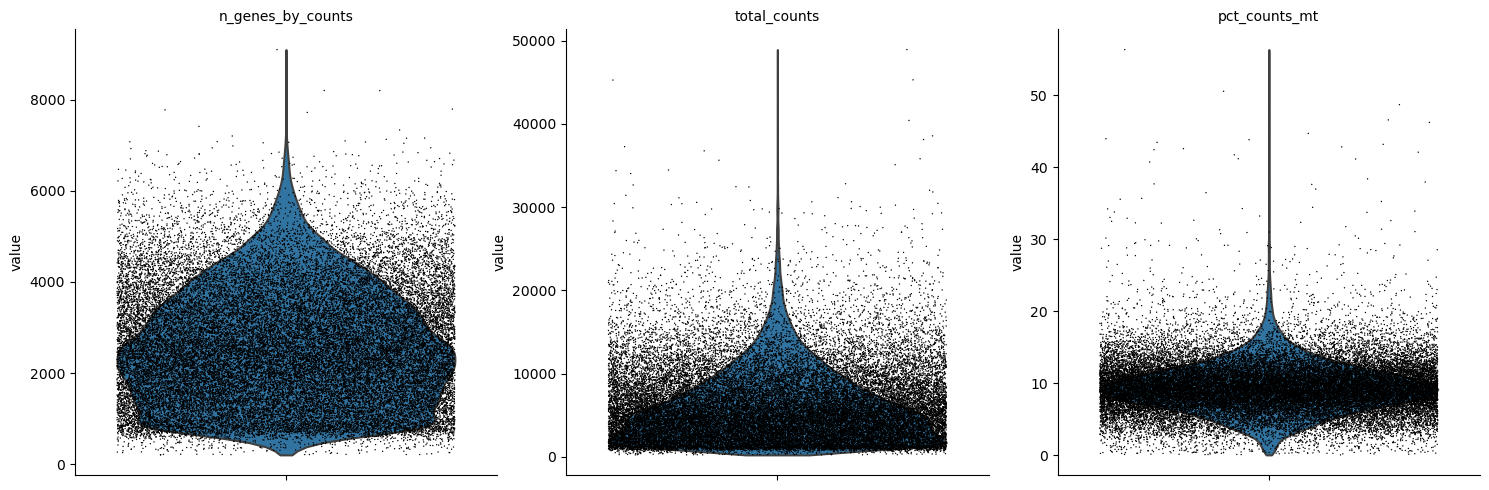

In [50]:
sc.pl.violin(adata_aggregated_gene, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

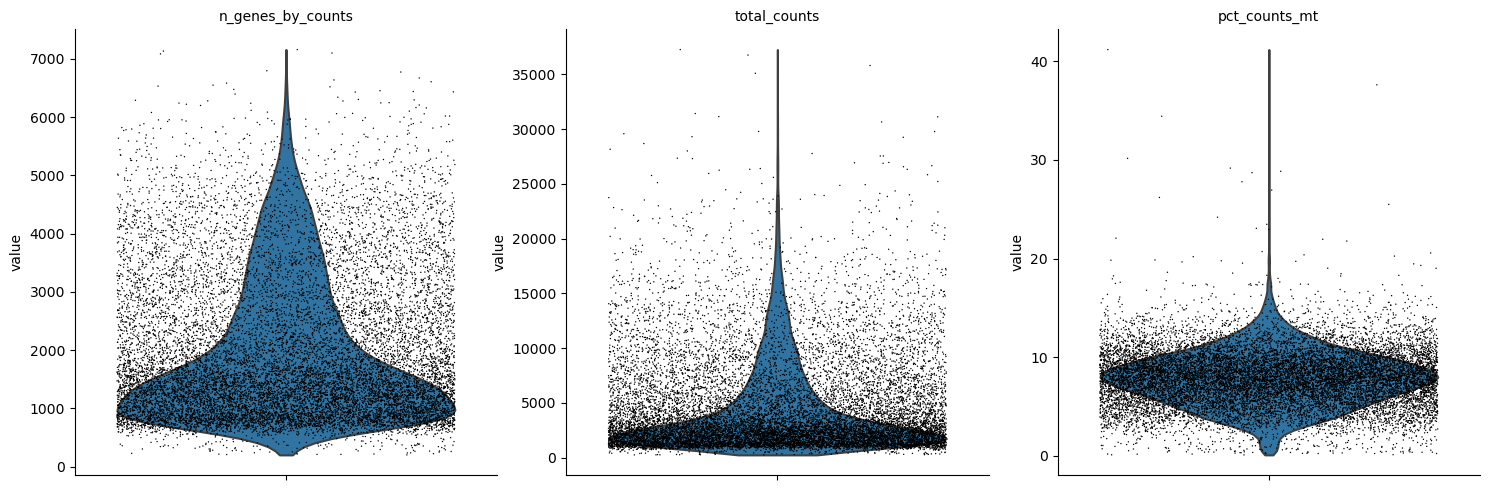

In [52]:
sc.pl.violin(adata_aggregated_gene[adata_aggregated_gene.obs['cell_type_major']=='day0_2'], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

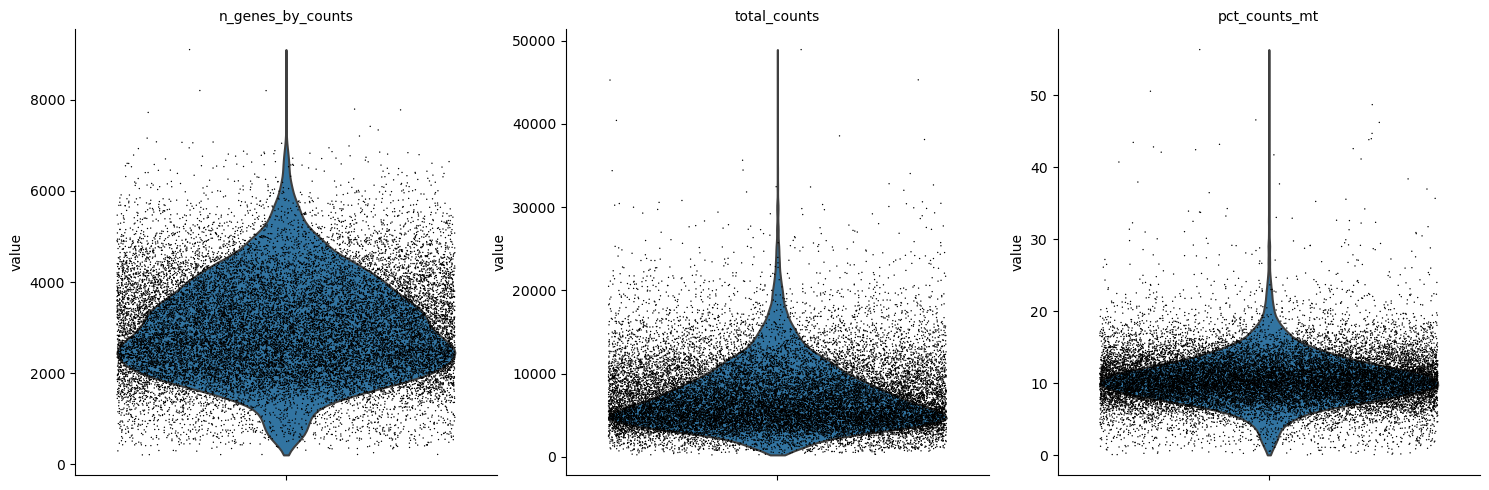

In [53]:
sc.pl.violin(adata_aggregated_gene[adata_aggregated_gene.obs['cell_type_major']!='day0_2'], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

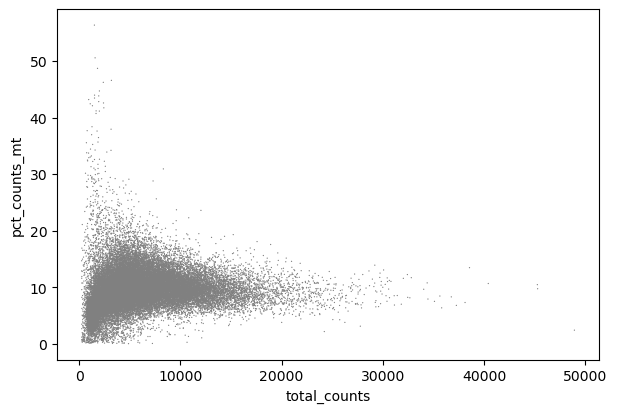

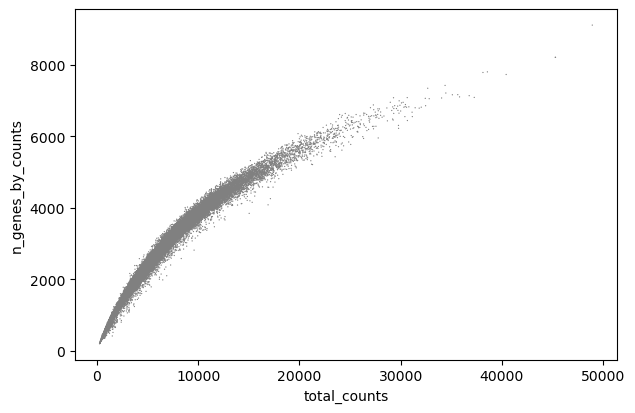

In [51]:
sc.pl.scatter(adata_aggregated_gene, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_aggregated_gene, x='total_counts', y='n_genes_by_counts')

In [64]:
adata_aggregated_gene

AnnData object with n_obs × n_vars = 36119 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [67]:
# filter cells
adata_aggregated_gene = adata_aggregated_gene[adata_aggregated_gene.obs.n_genes_by_counts < 5000, :]
adata_aggregated_gene = adata_aggregated_gene[adata_aggregated_gene.obs.n_genes_by_counts > 500, :]
adata_aggregated_gene = adata_aggregated_gene[adata_aggregated_gene.obs.pct_counts_mt < 20, :]
adata_aggregated_gene = adata_aggregated_gene[~((adata_aggregated_gene.obs.n_genes_by_counts > 3500) 
                                               & (adata_aggregated_gene.obs.cell_type_major=='day0_2')), :]

In [68]:
adata_aggregated_gene

View of AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [56]:
adata_aggregated_gene[adata_aggregated_gene.obs.n_genes_by_counts > 3500, :].obs['cell_type_major'].value_counts()

day5_6    2165
day3_4    1673
day0_2    1401
Name: cell_type_major, dtype: int64

In [69]:
adata_aggregated_gene.write('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_gene.h5ad')

In [228]:
adata_aggregated_peak.write('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_ATAC.h5ad')

... storing 'cell_type_major' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


# topic model for expression

In [70]:
adata_aggregated_gene=sc.read_h5ad("/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_gene.h5ad")

In [136]:
adata_aggregated_gene.raw =adata_aggregated_gene

In [188]:
adata_aggregated_gene.raw =adata_aggregated_gene
sc.pp.normalize_total(adata_aggregated_gene, target_sum=1e4)
sc.pp.log1p(adata_aggregated_gene)

In [ ]:
# sc.pp.highly_variable_genes(adata_aggregated_gene, min_mean=0.0125, max_mean=3, min_disp=0.5)
# # sc.pp.highly_variable_genes(adata, min_disp = 0.2)
sc.pp.highly_variable_genes(adata_aggregated_gene, min_disp = 0.1)
adata_aggregated_gene.var['exog'] = adata_aggregated_gene.var.highly_variable.copy()

In [84]:
adata_aggregated_gene.var['exog'].value_counts()

False    17632
True      5458
Name: exog, dtype: int64

In [87]:
adata_aggregated_gene.var['endog'] = adata_aggregated_gene.var.exog & (adata_aggregated_gene.var.dispersions_norm >= 0.4)

In [88]:
adata_aggregated_gene.var['endog'].value_counts()

False    19541
True      3549
Name: endog, dtype: int64

In [199]:
adata_aggregated_gene.layers['counts'] = adata_aggregated_gene.raw.to_adata().X.copy()


In [200]:
import mira
model = mira.topics.ExpressionTopicModel(
    endogenous_key='endog',
    exogenous_key='exog',
    counts_layer='counts',
    seed = 6,
    hidden=128, # to make the tutorial faster. In practice, use the default of 128!
)

In [90]:
model.get_learning_rate_bounds(adata_aggregated_gene, eval_every=1, upper_bound_lr=5)

INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog


Learning rate range test:   0%|          | 0/3034 [00:00<?, ?it/s]

ERROR:mira.topic_model.base:
Gradient overflow from too high learning rate, stopping test early.
INFO:mira.topic_model.base:Set learning rates to: (2.6294384883051996e-05, 0.15713964559029925)


(2.6294384883051996e-05, 0.15713964559029925)

<AxesSubplot:xlabel='Learning Rate', ylabel='Loss'>

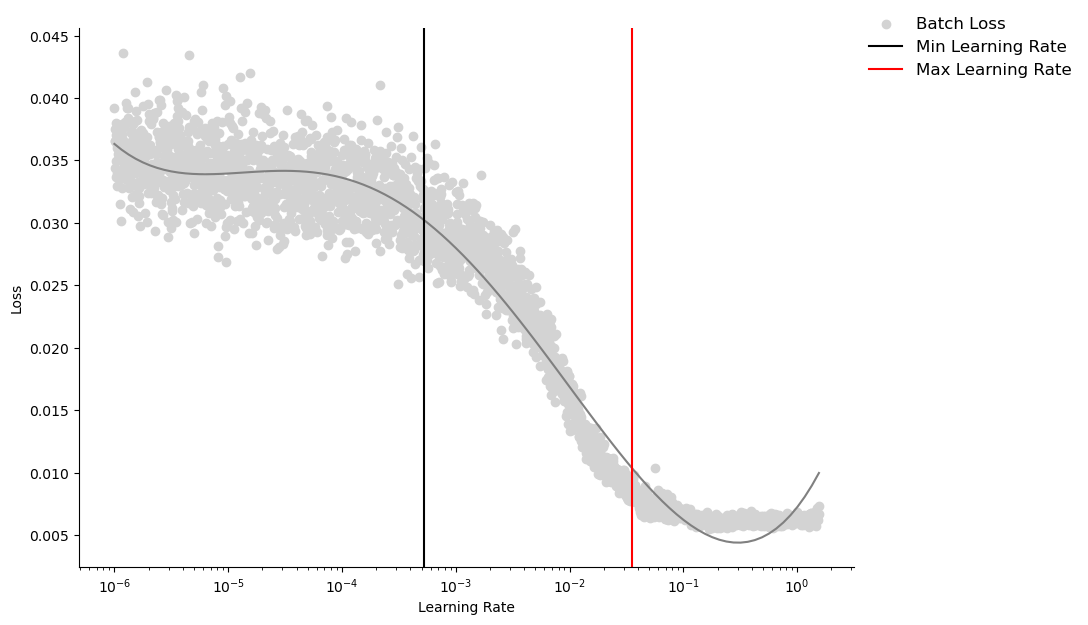

In [93]:
model.plot_learning_rate_bounds()

In [92]:
model.trim_learning_rate_bounds(3.0, 2.0)

INFO:mira.topic_model.base:Set learning rates to: (0.0005281368384410485, 0.03506259428623098)


(0.0005281368384410485, 0.03506259428623098)

In [205]:
tuner = mira.topics.TopicModelTuner(
    model,
    save_name = 'multiome_1st_donor_UPMC_aggr_RNA',
    seed = 6,
    iters=128, 
    max_topics = 56 
)



In [206]:
tuner.train_test_split(adata_aggregated_gene)


INFO:mira.adata_interface.topic_model:Added col: test_set
INFO:mira.adata_interface.core:Added cols to obs: test_set


In [ ]:
tuner.tune(adata_aggregated_gene, n_workers=8)

In [101]:
tuner.select_best_model(adata_aggregated_gene, top_n_trials=5,record_umaps=True)

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 64, 'beta': 0.9474, 'encoder_dropout': 0.0161, 'kl_strategy': 'cyclic', 'num_epochs': 37, 'num_layers': 2, 'num_topics': 32}


Epoch 0:   0%|          | 0/37 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 3.78137e-01


Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 64, 'beta': 0.9086, 'encoder_dropout': 0.0162, 'kl_strategy': 'cyclic', 'num_epochs': 38, 'num_layers': 3, 'num_topics': 42}


Epoch 0:   0%|          | 0/38 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 3.77953e-01


Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 64, 'beta': 0.9072, 'encoder_dropout': 0.0153, 'kl_strategy': 'cyclic', 'num_epochs': 36, 'num_layers': 2, 'num_topics': 33}


Epoch 0:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 3.78115e-01


Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 64, 'beta': 0.9083, 'encoder_dropout': 0.0209, 'kl_strategy': 'cyclic', 'num_epochs': 36, 'num_layers': 2, 'num_topics': 37}


Epoch 0:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 3.78210e-01


Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Training model with parameters: {'batch_size': 64, 'beta': 0.9545, 'encoder_dropout': 0.0160, 'kl_strategy': 'cyclic', 'num_epochs': 38, 'num_layers': 2, 'num_topics': 33}


Epoch 0:   0%|          | 0/38 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Score: 3.77996e-01


Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.topic_model.trainer:Set parameters to best combination: {'batch_size': 64, 'beta': 0.9086, 'encoder_dropout': 0.0162, 'kl_strategy': 'cyclic', 'num_epochs': 38, 'num_layers': 3, 'num_topics': 42}
INFO:mira.topic_model.trainer:Training model with all data.
INFO:mira.adata_interface.topic_model:Predicting expression from genes from col: exog
INFO:mira.adata_interface.topic_model:Using highly-variable genes from col: endog


Epoch 0:   0%|          | 0/38 [00:00<?, ?it/s]

INFO:mira.topic_model.base:Moving model to device: cpu


ExpressionTopicModel(
  (decoder): Decoder(
    (beta): Linear(in_features=42, out_features=5458, bias=False)
    (bn): BatchNorm1d(5458, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.2, inplace=False)
  )
  (encoder): ExpressionEncoder(
    (fc_layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=3550, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.016237565208726462, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.016237565208726462, inplace=False)
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=86, bias=True)
        (1): BatchNorm1d(86, eps=1e-05, momentum=0.1, affine

In [209]:
model.save('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/multiome_1st_donor_UPMC_aggr_gene_topic_model.cell_cycle_genes_removed.pth')


In [514]:

RNA_model = mira.topics.ExpressionTopicModel.load('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/multiome_1st_donor_UPMC_aggr_gene_topic_model.cell_cycle_genes_removed.pth')

adata_aggregated_gene=sc.read_h5ad("/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_gene.h5ad")

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [488]:
adata_aggregated_gene

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [515]:
adata_aggregated_gene.raw =adata_aggregated_gene

sc.pp.normalize_total(adata_aggregated_gene, target_sum=1e4)
sc.pp.log1p(adata_aggregated_gene)

In [516]:
adata_aggregated_gene.layers['counts'] = adata_aggregated_gene.raw.to_adata().X.copy()

In [517]:
RNA_model.predict(adata_aggregated_gene)

Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


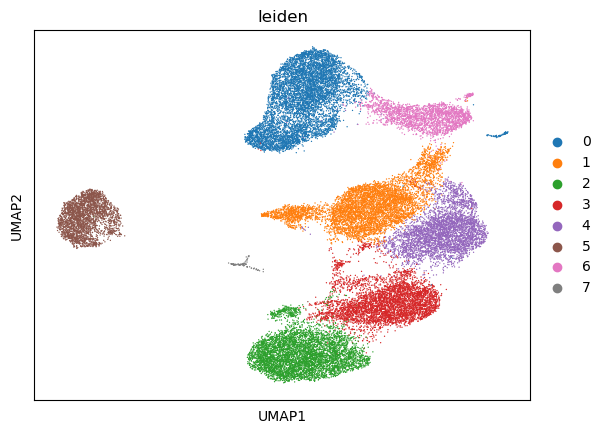

In [1638]:
sc.pl.umap(adata_aggregated_gene, 
           color=['leiden'],
#            color_map='Reds',
          )

# topic model for chromatin

In [ ]:
adata_aggregated_peak=sc.read_h5ad("/bgfs/hsingh/jif51/projects/human_B_cell/multiome_1st_donor_UPMC_aggr/adata_aggregated_ATAC.filtered.h5ad")

In [ ]:
adata_aggregated_peak.raw =adata_aggregated_peak
adata_aggregated_peak.layers['counts'] = adata_aggregated_peak.raw.to_adata().X.copy()

In [ ]:
atac_model = mira.topics.AccessibilityTopicModel(
    counts_layer='counts',
    dataset_loader_workers = 2,
    seed = 66,
    hidden=128, 
)

In [ ]:
atac_model.get_learning_rate_bounds(adata_aggregated_peak, eval_every=1, upper_bound_lr=0.01)

In [ ]:
from sklearn.model_selection import ShuffleSplit


atac_tuner = mira.topics.TopicModelTuner(
    atac_model,

    save_name = 'multiome_1st_donor_UPMC_aggr_ATAC_filtered',
    seed = 66,
    iters=64, 
    max_topics = 56, 
    cv = ShuffleSplit(n_splits=3, train_size=0.8), 
    batch_sizes = [64, 128], 
)

In [ ]:
atac_tuner.train_test_split(adata_aggregated_peak)

In [ ]:
atac_tuner.tune(adata_aggregated_peak)

In [ ]:
atac_tuner.select_best_model(adata_aggregated_peak, top_n_trials=5,record_umaps=False)

In [ ]:
atac_model.save('/bgfs/hsingh/jif51/projects/human_B_cell/multiome_1st_donor_UPMC_aggr/multiome_1st_donor_UPMC_aggr_atac_topic_model.filtered_peaks.pth')


In [857]:
atac_model = mira.topics.AccessibilityTopicModel.load('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/multiome_1st_donor_UPMC_aggr_atac_topic_model.filtered_peaks.pth')


INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [858]:
adata_aggregated_peak=sc.read_h5ad("/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_ATAC.filtered.h5ad")

In [859]:
adata_aggregated_peak.raw =adata_aggregated_peak
adata_aggregated_peak.layers['counts'] = adata_aggregated_peak.raw.to_adata().X.copy()

In [232]:

adata_aggregated_peak.raw =adata_aggregated_peak
adata_aggregated_peak.layers['counts'] = adata_aggregated_peak.raw.to_adata().X.copy()



In [860]:
atac_model.predict(adata_aggregated_peak)


Predicting latent vars:   0%|          | 0/71 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [608]:
adata_aggregated_peak.var['chr']=adata_aggregated_peak.var['gene_ids'].apply(lambda x:x.split(':')[0])
adata_aggregated_peak.var['start']=adata_aggregated_peak.var['gene_ids'].apply(lambda x:int(x.split(':')[1].split('-')[0]))

adata_aggregated_peak.var['end']=adata_aggregated_peak.var['gene_ids'].apply(lambda x:int(x.split(':')[1].split('-')[1]))


In [482]:
adata_aggregated_peak.var[['chr','start','end']].to_csv('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/ATAC_peaks_aggr.bed',sep='\t',header=False,index=False)

In [ ]:
mira.tools.motif_scan.logger.setLevel(logging.INFO) # make sure progress messages are displayed

mira.tl.get_motif_hits_in_peaks(adata_aggregated_peak,
                    genome_fasta='/media/RAIDArray/JingyuFan/library/igenomes/Homo_sapiens/NCBI/GRCh38/Sequence/WholeGenomeFasta/genome.fa',
                    chrom = 'chr', start = 'start', end = 'end') # indicate chrom, start, end of peaks



In [609]:
mira.tl.get_ChIP_hits_in_peaks(adata_aggregated_peak, 
    chrom = "chr", start = "start", end = "end",
    species = "hg38")



Loading gene info ...
Validating user-provided regions ...
INFO:mira.adata_interface.regulators:Added key to varm: chip_hits
INFO:mira.adata_interface.regulators:Added key to uns: chip


In [ ]:
topic_num=0
atac_model.get_enriched_TFs(adata_aggregated_peak, factor_type='motifs', topic_num=topic_num, top_quantile=0.1)
atac_model.get_enriched_TFs(adata_aggregated_peak, factor_type='chip', topic_num=topic_num, top_quantile=0.1)


In [469]:
motif_scores = atac_model.get_motif_scores(adata_aggregated_peak)


INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/71 [00:00<?, ?it/s]

/home/jingyu/miniconda3/envs/mira-env/lib/python3.7/site-packages/mira/adata_interface/regulators.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  X = norm_scores,


In [25]:
motif_scores_chip = atac_model.get_motif_scores(adata_aggregated_peak,factor_type='chip')


INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Imputing features:   0%|          | 0/64 [00:00<?, ?it/s]

/home/jingyu/miniconda3/envs/mira-env/lib/python3.7/site-packages/mira/adata_interface/regulators.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  X = norm_scores,


In [26]:
motif_scores_chip.var

,id,name,parsed_name
0,1006,EOMES,EOMES
1,1010,FOXH1,FOXH1
2,1011,FOXH1,FOXH1
3,1012,FOXP1,FOXP1
4,1013,FOXP1,FOXP1
...,...,...,...
6907,9508,TFAP2C,TFAP2C
6908,9509,TFAP2C,TFAP2C
6909,9510,TFAP2C,TFAP2C
6910,955,NANOG,NANOG


In [470]:
motif_scores.var = motif_scores.var.set_index('parsed_name')
motif_scores.var_names_make_unique()
motif_scores.obsm['X_umap'] = adata_aggregated_peak.obsm['X_umap']


In [28]:

motif_scores_chip.var = motif_scores_chip.var.reset_index().set_index('id')
motif_scores_chip.var_names_make_unique()
motif_scores_chip.obsm['X_umap'] = adata_aggregated_peak.obsm['X_umap']


# joint modelling

In [7]:
adata_aggregated_gene=sc.read_h5ad("/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_gene.h5ad")

adata_aggregated_gene.raw =adata_aggregated_gene
adata_aggregated_gene.layers['counts'] = adata_aggregated_gene.raw.to_adata().X.copy()
sc.pp.normalize_total(adata_aggregated_gene, target_sum=1e4)
sc.pp.log1p(adata_aggregated_gene)

RNA_model = mira.topics.ExpressionTopicModel.load('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/multiome_1st_donor_UPMC_aggr_gene_topic_model.cell_cycle_genes_removed.pth')
RNA_model.predict(adata_aggregated_gene)


INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21, topic_22, topic_23, topic_24, topic_25, topic_26, topic_27, topic_28, topic_29, topic_30, topic_31
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [9]:
adata_aggregated_peak=sc.read_h5ad("/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_ATAC.h5ad")
adata_aggregated_peak.raw =adata_aggregated_peak
adata_aggregated_peak.layers['counts'] = adata_aggregated_peak.raw.to_adata().X.copy()

atac_model = mira.topics.AccessibilityTopicModel.load('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/multiome_1st_donor_UPMC_aggr_atac_topic_model.filtered_peaks.pth')

atac_model.predict(adata_aggregated_peak)

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


Predicting latent vars:   0%|          | 0/71 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added key to obsm: X_topic_compositions
INFO:mira.adata_interface.topic_model:Added cols: topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, topic_8, topic_9, topic_10, topic_11, topic_12, topic_13, topic_14, topic_15, topic_16, topic_17, topic_18, topic_19, topic_20, topic_21
INFO:mira.adata_interface.core:Added key to varm: topic_feature_compositions
INFO:mira.adata_interface.core:Added key to varm: topic_feature_activations
INFO:mira.adata_interface.topic_model:Added key to uns: topic_dendogram


In [10]:
RNA_model.get_umap_features(adata_aggregated_gene, box_cox=0.1)
atac_model.get_umap_features(adata_aggregated_peak, box_cox=0.1)

INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.core:Added key to obsm: X_umap_features


In [871]:
adata_aggregated_gene

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'topic_dendogram'
    obsm: 'X_topic_compositions'
    varm: 'topic_feature_compositions', 'topic_feature_activations'
    layers: 'counts'

In [11]:
adata_aggregated_gene, adata_aggregated_peak = mira.utils.make_joint_representation(adata_aggregated_gene, adata_aggregated_peak)

INFO:mira.adata_interface.utils:32418 out of 36306 cells shared between datasets (89%).
INFO:mira.adata_interface.utils:Key added to obsm: X_joint_umap_features


2023-08-31 14:58:35.098044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 14:58:35.434531: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 14:58:35.491452: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-31 14:58:35.491473: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

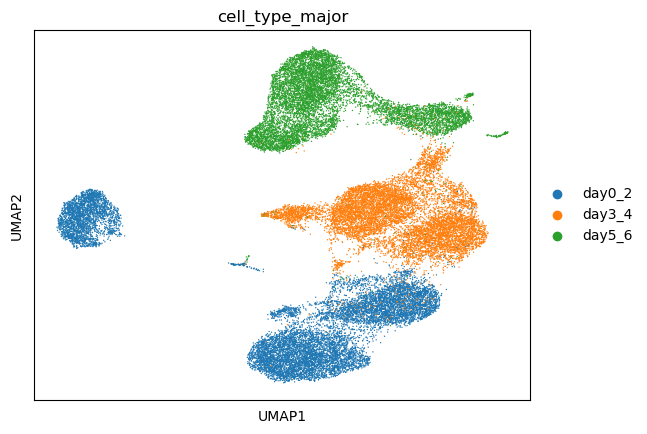

In [12]:
sc.pp.neighbors(adata_aggregated_gene, use_rep = 'X_joint_umap_features', metric = 'manhattan',
               n_neighbors = 20)

sc.tl.umap(adata_aggregated_gene, min_dist=0.3, negative_sample_rate=5,random_state=0)

sc.pl.umap(adata_aggregated_gene, 
           color=['cell_type_major'],
#            color_map='Reds',
          )


In [16]:
sc.tl.leiden(adata_aggregated_gene,resolution=0.4,random_state=6)

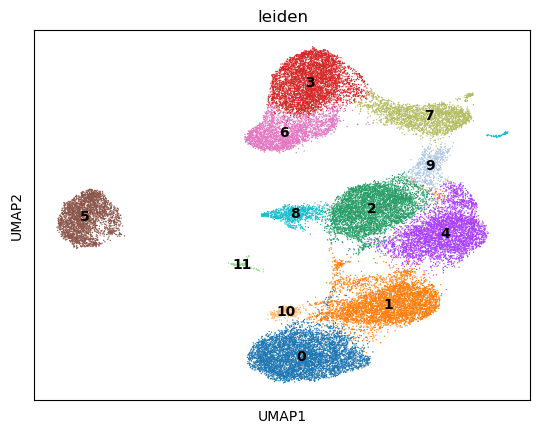

In [13]:
sc.pl.umap(adata_aggregated_gene, 
           color=['leiden'],
           legend_loc='on data',
          )

In [15]:
adata_aggregated_gene.write('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_gene.leiden.h5ad')

In [23]:
adata_aggregated_peak_joint.write('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_peak.leiden.h5ad')


# gene scores

In [893]:
sc.tl.score_genes(adata_aggregated_gene, 
                   list_g1s, 
                   ctrl_size=300, 
                   gene_pool=None, 
                   n_bins=25, 
                   score_name='score_G1S', 
                   random_state=6, 
                   copy=False, 
                   use_raw=False)


sc.tl.score_genes(adata_aggregated_gene, 
                   list_g2m, 
                   ctrl_size=300, 
                   gene_pool=None, 
                   n_bins=25, 
                   score_name='score_G2M', 
                   random_state=6, 
                   copy=False, 
                   use_raw=False)


sc.tl.score_genes(adata_aggregated_gene, 
                   list_myc_up, 
                   ctrl_size=300, 
                   gene_pool=None, 
                   n_bins=25, 
                   score_name='score_myc_up', 
                   random_state=6, 
                   copy=False, 
                   use_raw=False)

sc.tl.score_genes(adata_aggregated_gene, 
                   list_apoptosis, 
                   ctrl_size=300, 
                   gene_pool=None, 
                   n_bins=25, 
                   score_name='score_apoptosis', 
                   random_state=6, 
                   copy=False, 
                   use_raw=False)




In [895]:

sc.tl.score_genes(adata_aggregated_gene, 
                   list_g1s_2, 
                   ctrl_size=300, 
                   gene_pool=None, 
                   n_bins=25, 
                   score_name='score_G1S_2', 
                   random_state=6, 
                   copy=False, 
                   use_raw=False)


sc.tl.score_genes(adata_aggregated_gene, 
                   list_g2m_2, 
                   ctrl_size=300, 
                   gene_pool=None, 
                   n_bins=25, 
                   score_name='score_G2M_2', 
                   random_state=6, 
                   copy=False, 
                   use_raw=False)


In [16]:
adata_aggregated_peak_joint.obs['cell_index']=adata_aggregated_peak_joint.obs.index.tolist()

In [17]:
dict_temp=adata_aggregated_gene.obs[['leiden']].to_dict()['leiden']
adata_aggregated_peak_joint.obs['leiden_joint']=list(map(lambda x:dict_temp[x],adata_aggregated_peak_joint.obs.index.tolist()))

In [931]:
adata_aggregated_peak_joint.obs.head()

,cell_type_major,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,mira_connected_components,mira_pseudotime,PB_prob,mid_prob,GC_prob,mem_like_prob,differentiation_entropy,tree_states,cell_index,leiden_joint
AAACAGCCAAAGCTAA-1,day0_2,0.005099,0.001026,0.284882,0.001337,0.000280,0.002770,0.002660,0.052731,0.000125,...,0,12.885143,0.003989,0.002893,0.059919,0.024037,0.756259,mem_like,AAACAGCCAAAGCTAA-1,5
AAACAGCCAAGCCACT-3,day5_6,0.055097,0.046587,0.011382,0.036129,0.022273,0.048213,0.030627,0.008559,0.020603,...,0,7.041902,0.000002,0.011026,0.995244,0.000003,0.000068,GC,AAACAGCCAAGCCACT-3,0
AAACAGCCAAGGTGCA-1,day0_2,0.015325,0.007831,0.020335,0.002648,0.005557,0.032762,0.050615,0.008903,0.003032,...,0,5.479708,0.000026,0.000026,0.072205,0.000322,0.031635,GC,AAACAGCCAAGGTGCA-1,3
AAACAGCCAAGTTATC-1,day0_2,0.012342,0.008782,0.110981,0.002043,0.000778,0.019440,0.006577,0.022760,0.001000,...,0,3.951754,0.000016,0.000187,0.044201,0.000195,0.031431,"GC, PB, mem_like",AAACAGCCAAGTTATC-1,2
AAACAGCCAATAGCCC-1,day0_2,0.024280,0.002478,0.204839,0.002795,0.002232,0.010186,0.016164,0.009534,0.001674,...,0,3.083875,0.000019,0.000220,0.054055,0.000239,0.031446,"GC, PB, mem_like",AAACAGCCAATAGCCC-1,2


INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


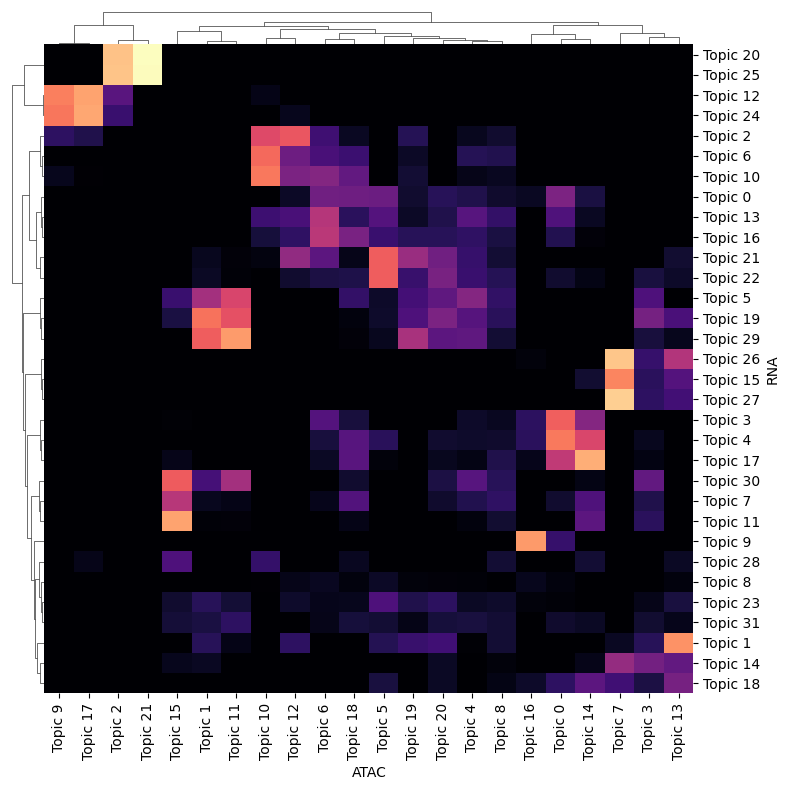

In [781]:
cross_correlation = mira.tl.get_topic_cross_correlation(adata_aggregated_gene_joint, adata_aggregated_peak_joint)
g=sns.clustermap(cross_correlation, 
               vmin = 0,
               cmap = 'magma', method='ward',
               dendrogram_ratio=0.05, 
               cbar_pos=None, 
               figsize=(8,8))


In [782]:
g.savefig('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/cross_correlation.pdf')

In [160]:
mira.tools.motif_scan.logger.setLevel(logging.INFO) # make sure progress messages are displayed

mira.tl.get_motif_hits_in_peaks(adata_aggregated_peak_joint,
                    genome_fasta='/media/RAIDArray/JingyuFan/library/igenomes/Homo_sapiens/NCBI/GRCh38/Sequence/WholeGenomeFasta/genome.fa',
                    chrom = 'chr', start = 'start', end = 'end') # indicate chrom, start, end of peaks

INFO:mira.tools.motif_scan:Getting peak sequences ...
191255it [00:15, 12036.24it/s]
INFO:mira.tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:mira.tools.motif_scan:Building motif background models ...
INFO:mira.tools.motif_scan:Starting scan ...
INFO:mira.tools.motif_scan:Found 1000000 motif hits ...
INFO:mira.tools.motif_scan:Found 2000000 motif hits ...
INFO:mira.tools.motif_scan:Found 3000000 motif hits ...
INFO:mira.tools.motif_scan:Found 4000000 motif hits ...
INFO:mira.tools.motif_scan:Found 5000000 motif hits ...
INFO:mira.tools.motif_scan:Found 6000000 motif hits ...
INFO:mira.tools.motif_scan:Found 7000000 motif hits ...
INFO:mira.tools.motif_scan:Found 8000000 motif hits ...
INFO:mira.tools.motif_scan:Found 9000000 motif hits ...
INFO:mira.tools.motif_scan:Found 10000000 motif hits ...
INFO:mira.tools.motif_scan:Found 11000000 motif hits ...
INFO:mira.tools.motif_scan:Found 12000000 motif hits ...
INFO:mira.tools.motif_scan:Found 13000000 motif hits 

In [161]:
mira.tl.get_ChIP_hits_in_peaks(adata_aggregated_peak_joint, 
    chrom = "chr", start = "start", end = "end",
    species = "hg38")


Loading gene info ...
Validating user-provided regions ...
INFO:mira.adata_interface.regulators:Added key to varm: chip_hits
INFO:mira.adata_interface.regulators:Added key to uns: chip


In [65]:
topic_num=7
atac_model.get_enriched_TFs(adata_aggregated_peak_joint, factor_type='chip', topic_num=topic_num, top_quantile=0.1)


Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

In [86]:
temp=[]
for i in range(22):
    atac_model.get_enriched_TFs(adata_aggregated_peak_joint, factor_type='chip', topic_num=i, top_quantile=0.1)
    df_temp=pd.DataFrame(atac_model.get_enrichments(i,factor_type='chip'))\
    .sort_values('pval').drop_duplicates('name')
    df_temp['log_p_value']=df_temp['pval'].apply(lambda x: -np.log10(x+1e-300))
    df_temp = df_temp[['name','log_p_value']]
    df_temp['topic']=i
    temp.append(df_temp)

    
df_peak_topic_chip_enrichment=pd.concat(temp, ignore_index=True)

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

Finding enrichments:   0%|          | 0/6912 [00:00<?, ?it/s]

In [70]:
df_peak_topic_chip_enrichment.head()

,name,log_p_value,topic
0,CDK9,300.0,0
1,TCF4,300.0,0
2,MED1,300.0,0
3,HDAC2,300.0,0
4,BRD3,300.0,0


In [87]:
df_peak_topic_chip_enrichment_pivot = pd.pivot_table(df_peak_topic_chip_enrichment,values='log_p_value', index='name', columns='topic')

In [88]:
df_peak_topic_chip_enrichment_pivot.to_csv('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/df_peak_topic_chip_enrichment_pivot.tsv',sep='\t',header=True,index=True)

In [90]:
df_temp=pd.read_excel('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/tf_chipseq_list.xlsx')

In [91]:
df_plot=df_peak_topic_chip_enrichment_pivot.loc[df_temp['factor'].to_list(),:]

In [92]:
df_plot.head()

topic,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
name,,,,,,,,,,,,,,,,,,,,,
PAX5,54.907325,33.011384,300.000000,3.292502e-10,3.292502e-10,0.002002,3.292502e-10,128.760636,3.292502e-10,8.814238,...,3.292502e-10,20.581963,16.282739,84.345966,300.000000,300.000000,3.292502e-10,3.292501e-10,3.292502e-10,300.000000
BATF,0.002215,41.564905,300.000000,1.001638e+02,2.424018e-10,23.624330,2.423923e-10,15.608653,2.423911e-10,10.040216,...,2.028067e-04,300.000000,29.479104,0.950788,41.648493,80.305570,1.680674e-09,2.644449e-07,2.423911e-10,300.000000
CTCF,105.316394,0.036775,300.000000,3.000000e+02,1.946937e+02,0.885052,1.994886e+00,77.196031,1.093654e+02,74.803222,...,5.011739e-01,0.163591,300.000000,149.598282,300.000000,203.243062,8.537351e+01,2.711703e+01,1.746253e+02,300.000000
TSC22D4,4.342014,0.002344,28.830001,1.627128e+00,9.982734e-01,3.228977,3.626127e-01,2.790455,8.248990e-01,3.990596,...,1.536667e+00,3.727420,1.536667,1.399564,111.509275,62.236868,1.090656e-01,1.585839e-02,9.982734e-01,82.211704
EZH2,35.235089,0.054978,300.000000,3.909312e+00,8.988704e-01,0.039975,3.184514e+00,16.822998,1.660335e+00,2.486501,...,2.638556e+00,0.048826,13.439885,1.507756,300.000000,300.000000,9.463049e-02,9.269286e-03,4.760731e-01,300.000000


In [19]:
adata_aggregated_peak.var['chr']=adata_aggregated_peak.var['gene_ids'].apply(lambda x:x.split(':')[0])
adata_aggregated_peak.var['start']=adata_aggregated_peak.var['gene_ids'].apply(lambda x:int(x.split(':')[1].split('-')[0]))

adata_aggregated_peak.var['end']=adata_aggregated_peak.var['gene_ids'].apply(lambda x:int(x.split(':')[1].split('-')[1]))

In [20]:
adata_aggregated_peak.var['selected_chrom']=adata_aggregated_peak.var['chr'].apply(lambda x: x.startswith('chr'))

In [558]:
adata_aggregated_peak.var[adata_aggregated_peak.var['selected_chrom']==True][['chr','start','end']].to_csv('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/multiome_1st_donor_UPMC_aggr.peaks.bed',sep='\t',header=False,index=False)

# Regulatory Potential modeling

In [632]:
mira.datasets.hg38_chrom_sizes()
mira.datasets.hg38_tss_data()

INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/hg38.chrom.sizes


INFO:mira.datasets.datasets:Dataset contents:
	* mira-datasets/hg38_tss_data.bed12


In [21]:
adata_aggregated_peak_joint.var['chr']=adata_aggregated_peak_joint.var['gene_ids'].apply(lambda x:x.split(':')[0])
adata_aggregated_peak_joint.var['start']=adata_aggregated_peak_joint.var['gene_ids'].apply(lambda x:int(x.split(':')[1].split('-')[0]))
adata_aggregated_peak_joint.var['end']=adata_aggregated_peak_joint.var['gene_ids'].apply(lambda x:int(x.split(':')[1].split('-')[1]))

In [22]:
mira.tl.get_distance_to_TSS(adata_aggregated_peak_joint,
                            tss_data='mira-datasets/hg38_tss_data.bed12',
                            genome_file='mira-datasets/hg38.chrom.sizes')


INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [126]:
adata_aggregated_gene_raw=adata_aggregated_gene_joint.raw.to_adata()
adata_aggregated_gene_raw.raw =adata_aggregated_gene_raw
adata_aggregated_gene_raw.layers['counts'] = adata_aggregated_gene_raw.raw.to_adata().X.copy()
rp_args = dict(expr_adata = adata_aggregated_gene_raw, atac_adata= adata_aggregated_peak_joint)

In [130]:
rp_genes = list(RNA_model.features[RNA_model.highly_variable])
for topic in range(RNA_model.num_topics):
    rp_genes.extend(RNA_model.get_top_genes(topic, 200))
rp_genes = list(set(rp_genes))

In [132]:
sc.pp.highly_variable_genes(adata_aggregated_gene_joint, min_disp = 0.1)
adata_aggregated_gene_joint.var['exog'] = adata_aggregated_gene_joint.var.highly_variable.copy()

In [25]:
adata_aggregated_gene_joint.var['exog'].value_counts()

False    17632
True      5458
Name: exog, dtype: int64

In [133]:
rp_genes+=adata_aggregated_gene_joint.var[adata_aggregated_gene_joint.var['exog']==True].index.tolist()
rp_genes = list(set(rp_genes))

In [652]:
len(rp_genes)

5458

In [135]:
df_gene_tss=pd.read_csv('mira-datasets/hg38_tss_data.bed12',sep='\t')

In [640]:
df_gene_tss.head()

,#chrom,#txStart,#txEnd,#geneSymbol,#score,#strand,#thickStart,#thickEnd,#itemRGB,#exonCount,#blockSizes,#blockStarts
0,chr1,11868,14409,DDX11L1,0,+,0,0,0,3,"359,109,1189","0,744,1352"
1,chr1,14403,29570,WASH7P,0,-,0,0,0,11,"98,34,152,159,198,136,137,147,99,154,37","0,601,1392,2203,2454,2829,3202,3511,3864,10334..."
2,chr1,17368,17436,MIR6859-1,0,-,0,0,0,1,68,0
3,chr1,29553,31097,MIR1302-2HG,0,+,0,0,0,3,"486,104,122","0,1010,1422"
4,chr1,30365,30503,MIR1302-2,0,+,0,0,0,1,138,0


In [136]:
rp_genes=list(set(rp_genes) & set(df_gene_tss['#geneSymbol'].tolist()))

In [137]:
len(rp_genes)

4307

In [140]:
litemodel = mira.rp.LITE_Model.load_dir(
    expr_model = RNA_model,
    accessibility_model = atac_model,
    prefix='./multiome_1st_donor_UPMC_aggr/MIRA_out/rpmodels_all_peaks/'
)

In [655]:
litemodel = mira.rp.LITE_Model(expr_model = RNA_model,
                              accessibility_model=atac_model,
                              genes = rp_genes)

In [658]:
!mkdir -p ./multiome_1st_donor_UPMC_aggr/MIRA_out/rpmodels_all_peaks/

litemodel.fit(**rp_args, n_workers=32,
              callback = mira.rp.SaveCallback('./multiome_1st_donor_UPMC_aggr/MIRA_out/rpmodels_all_peaks/'))

Fitting models:   0%|          | 0/4307 [00:00<?, ?it/s]

/home/jingyu/miniconda3/envs/mira-env/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


In [162]:
litemodel.probabilistic_isd(**rp_args, 
                            n_samples=1500, 
                            checkpoint='/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/probabilistic_isd.motif.h5', 
#                             atac_topic_comps_key='X_topic_compositions', 
                            factor_type='motifs',
                            n_workers = 1)

Predicting TF influence:   0%|          | 0/4306 [00:00<?, ?it/s]

INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [141]:
litemodel.probabilistic_isd(**rp_args, 
                            n_samples=1500, 
                            checkpoint='/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/probabilistic_isd.chip.h5', 
#                             atac_topic_comps_key='X_topic_compositions', 
                            factor_type='chip',
                            n_workers = 1)

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm


Calculating softmax summary data:   0%|          | 0/64 [00:00<?, ?it/s]

INFO:mira.adata_interface.core:Added cols to obs: softmax_denom


Predicting TF influence:   0%|          | 0/4306 [00:00<?, ?it/s]

INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'chip-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: chip-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: chip


In [164]:
adata_aggregated_gene_raw

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'model_read_scale', 'softmax_denom'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'topic_dendogram', 'neighbors', 'umap', 'cell_type_major_colors', 'chip', 'motifs'
    obsm: 'X_topic_compositions', 'X_umap_features', 'X_joint_umap_features', 'X_umap'
    varm: 'chip-prob_deletion', 'motifs-prob_deletion'
    layers: 'counts', 'chip-informative_sam

In [166]:
rp_args

{'expr_adata': AnnData object with n_obs × n_vars = 32418 × 23090
     obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'model_read_scale', 'softmax_denom'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: 'log1p', 'topic_dendogram', 'neighbors', 'umap', 'cell_type_major_colors', 'chip', 'motifs'
     obsm: 'X_topic_compositions', 'X_umap_features', 'X_joint_umap_features', 'X_umap'
     varm: 'chip-prob_deletion', 'motifs-prob_deletion'
     layers: 'counts', 

In [165]:
rp_args['expr_adata'].write('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_gene.ISD.h5ad')
rp_args['atac_adata'].write('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/adata_aggregated_ATAC.ISD.h5ad')

In [ ]:
isd_matrix_motifs = mira.utils.fetch_ISD_matrix(adata_aggregated_gene_raw,
                                                 factor_type='motifs',
                                                id_column='name',
#                                                 id_column='id',
                                               )

In [35]:
isd_matrix_motifs.head()

,ARX,TFAP2A.VAR.2,PPARD,DPBF3,AT3G24120,EMX2,NKX2-8,KAN4,NOBOX,WRKY47,...,SIX3,VSX1,ZNF282,HES2,CG11617,C15,ESE3,WRKY7,ESR1,HSFB2B
LINC01128,5.194476e-02,-7.209352,-0.079429,-0.018097,-2.098334e-01,0.003921,0.346386,-2.891508e-03,3.770162e-03,-0.003856,...,0.099084,-0.126769,-0.020159,-0.419524,-0.001601,-0.098910,0.267565,-0.010526,-6.687122e-01,-1.892961e-01
LINC00115,2.328616e-01,-9.403819,-0.209265,0.212715,1.470974e+00,0.180817,-0.157911,-1.573249e-02,1.798788e-01,0.052141,...,0.223602,-0.108017,0.267596,-2.122160,0.232946,-0.110561,-1.593028,-0.013678,1.234272e+00,1.226107e+00
LINC01342,4.373279e+00,35.749052,2.661715,0.396316,1.107642e+00,0.013262,2.092226,5.795048e+00,4.363269e+00,-1.911105,...,0.041232,0.002308,6.166591,-2.511018,0.009665,0.002307,29.761640,0.060212,5.859788e+00,4.162645e+00
TNFRSF18,6.316441e-10,2.779543,-0.000079,-0.613562,1.385309e-03,0.000000,0.911644,6.316441e-10,6.316441e-10,-0.617191,...,0.000000,0.000000,0.000353,-5.295087,0.000000,0.000000,5.780811,0.000000,-1.335321e-02,6.316441e-10
TNFRSF4,0.000000e+00,1.353284,0.000000,-0.000025,2.023312e-07,0.000000,0.050986,0.000000e+00,0.000000e+00,-0.000013,...,0.000000,0.000000,0.000000,0.114830,0.000000,0.000000,-4.862569,0.000000,2.023312e-07,0.000000e+00


In [142]:
isd_matrix_chip = mira.utils.fetch_ISD_matrix(adata_aggregated_gene_raw,
                                              id_column='name',
#                                                 id_column='id',
                                                 factor_type='chip'
                                             )

In [ ]:
mira.utils.fetch_ISD_matrix(adata_aggregated_gene_raw,
                                              id_column='name',
#                                                 id_column='id',
                                                 factor_type='motifs'
                                             )

In [151]:
isd_matrix_chip.to_csv("/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/ISD_matrix.chip.tsv", sep="\t",header=True, index=True)

In [152]:
# save json
import json

with open('/media/RAIDArray/JingyuFan/projects/human_B_cell/multiome_230104/multiome_1st_donor_UPMC_aggr/MIRA_out/ISD_matrix.chip.json', 'w') as f:
    json.dump(adata_aggregated_gene_raw.uns['chip'], f)

In [144]:
adata_aggregated_gene_raw['chip-informative_samples']

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'model_read_scale', 'softmax_denom'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'topic_dendogram', 'neighbors', 'umap', 'cell_type_major_colors', 'chip'
    obsm: 'X_topic_compositions', 'X_umap_features', 'X_joint_umap_features', 'X_umap'
    varm: 'chip-prob_deletion'
    layers: 'counts', 'chip-informative_samples'
    obsp: 'distances', 'conn

In [143]:
isd_matrix_chip.head()

,EOMES,FOXH1,FOXH1,FOXP1,FOXP1,SMAD2/3,SMAD2/3,SMAD2/3,SMAD2/3,SMAD3,...,HIF1A,HIF1A,FOXK1,FOXK1,TFAP2C,TFAP2C,TFAP2C,TFAP2C,NANOG,PRDM14
LINC01128,-0.122121,-0.014582,-0.014682,-6.731109,-7.162315e+00,-1.468203e-02,-1.468203e-02,-0.042570,-0.590595,-1.468203e-02,...,0.0,-0.015253,-0.014479,-0.005537,-0.029675,-0.508804,-3.103675,-0.002044,-2.815250e+00,-0.014682
LINC00115,-0.902641,0.001528,-0.006604,-7.016697,-8.841107e+00,-6.603672e-03,-6.603672e-03,-0.864963,-1.612247,-6.603672e-03,...,0.0,0.018388,0.002129,0.039642,0.045165,-2.065736,-3.501191,-0.640813,-3.027643e+00,-0.006439
LINC01342,-2.791952,0.005101,0.000082,-14.052099,-1.406206e+01,-1.444960e-09,-1.444960e-09,-4.680346,-0.954726,-1.444960e-09,...,0.0,-0.512425,0.043336,0.038046,15.730456,-10.499659,-11.912314,-10.184273,-1.091990e+01,-0.059762
TNFRSF18,-0.611650,0.000000,0.000000,-0.611650,6.316441e-10,0.000000e+00,0.000000e+00,-0.611650,0.000000,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,-3.849033,0.298758,-0.611900,-3.653616,1.237613e-07,0.000000
TNFRSF4,-0.000025,0.000000,0.000000,-0.000025,0.000000e+00,0.000000e+00,0.000000e+00,-0.000025,0.000000,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.223944,0.051110,-0.000025,0.311463,0.000000e+00,0.000000


In [37]:
isd_matrix_chip.head()

,EOMES,FOXH1,FOXH1,FOXP1,FOXP1,SMAD2/3,SMAD2/3,SMAD2/3,SMAD2/3,SMAD3,...,HIF1A,HIF1A,FOXK1,FOXK1,TFAP2C,TFAP2C,TFAP2C,TFAP2C,NANOG,PRDM14
LINC01128,-0.122121,-0.014582,-0.014682,-6.731109,-7.162315e+00,-1.468203e-02,-1.468203e-02,-0.042570,-0.590595,-1.468203e-02,...,0.0,-0.015253,-0.014479,-0.005537,-0.029675,-0.508804,-3.103675,-0.002044,-2.815250e+00,-0.014682
LINC00115,-0.902641,0.001528,-0.006604,-7.016697,-8.841107e+00,-6.603672e-03,-6.603672e-03,-0.864963,-1.612247,-6.603672e-03,...,0.0,0.018388,0.002129,0.039642,0.045165,-2.065736,-3.501191,-0.640813,-3.027643e+00,-0.006439
LINC01342,-2.791952,0.005101,0.000082,-14.052099,-1.406206e+01,-1.444960e-09,-1.444960e-09,-4.680346,-0.954726,-1.444960e-09,...,0.0,-0.512425,0.043336,0.038046,15.730456,-10.499659,-11.912314,-10.184273,-1.091990e+01,-0.059762
TNFRSF18,-0.611650,0.000000,0.000000,-0.611650,6.316441e-10,0.000000e+00,0.000000e+00,-0.611650,0.000000,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,-3.849033,0.298758,-0.611900,-3.653616,1.237613e-07,0.000000
TNFRSF4,-0.000025,0.000000,0.000000,-0.000025,0.000000e+00,0.000000e+00,0.000000e+00,-0.000025,0.000000,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.223944,0.051110,-0.000025,0.311463,0.000000e+00,0.000000


In [1119]:
isd_matrix_chip_id = mira.utils.fetch_ISD_matrix(adata_aggregated_gene_raw,
#                                               id_column='name',
                                                id_column='id',
                                                 factor_type='chip')

In [1120]:
isd_matrix_chip_id.head()

,1006,1010,1011,1012,1013,1080,1081,1082,1083,1084,...,9495,9496,9505,9506,9507,9508,9509,9510,955,966
LINC01128,-0.122121,-0.014582,-0.014682,-6.731109,-7.162315e+00,-1.468203e-02,-1.468203e-02,-0.042570,-0.590595,-1.468203e-02,...,0.0,-0.015253,-0.014479,-0.005537,-0.029675,-0.508804,-3.103675,-0.002044,-2.815250e+00,-0.014682
LINC00115,-0.902641,0.001528,-0.006604,-7.016697,-8.841107e+00,-6.603672e-03,-6.603672e-03,-0.864963,-1.612247,-6.603672e-03,...,0.0,0.018388,0.002129,0.039642,0.045165,-2.065736,-3.501191,-0.640813,-3.027643e+00,-0.006439
LINC01342,-2.791952,0.005101,0.000082,-14.052099,-1.406206e+01,-1.444960e-09,-1.444960e-09,-4.680346,-0.954726,-1.444960e-09,...,0.0,-0.512425,0.043336,0.038046,15.730456,-10.499659,-11.912314,-10.184273,-1.091990e+01,-0.059762
TNFRSF18,-0.611650,0.000000,0.000000,-0.611650,6.316441e-10,0.000000e+00,0.000000e+00,-0.611650,0.000000,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,-3.849033,0.298758,-0.611900,-3.653616,1.237613e-07,0.000000
TNFRSF4,-0.000025,0.000000,0.000000,-0.000025,0.000000e+00,0.000000e+00,0.000000e+00,-0.000025,0.000000,0.000000e+00,...,0.0,0.000000,0.000000,0.000000,0.223944,0.051110,-0.000025,0.311463,0.000000e+00,0.000000


In [1181]:
isd_matrix_chip_id.loc[:,select_sample_id].sort_values().tail(200).head()

LINC02694    58.020949
FAAH2        58.938372
TSPAN13      59.061776
DEF8         59.299718
AMMECR1      59.490820
Name: 46109, dtype: float64

In [977]:
topic_num=27

In [978]:
isd_results = mira.tl.driver_TF_test(adata_aggregated_gene_raw, 
                                     geneset=RNA_model.get_top_genes(topic_num, 200),
                                    factor_type='motifs')

pd.DataFrame(isd_results).sort_values('pval').head(15)

INFO:mira.tools.tf_targeting:Testing with 178 query genes and 4128 background genes, against 1646 factors


Testing factors:   0%|          | 0/1646 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
501,MA0103.3,ZEB1,ZEB1,1.169628e-36,571880.5
1531,MA1621.1,RBPJL,RBPJL,8.486649e-26,536870.0
289,MA1620.1,PTF1A.VAR.3,PTF1A.VAR.3,2.038117e-24,531896.0
274,MA1631.1,ASCL1.VAR.2,ASCL1.VAR.2,2.301787e-20,516357.5
709,MA0139.1,CTCF,CTCF,1.798688e-19,512716.0
1184,MA0830.2,TCF4,TCF4,4.097285e-19,511232.5
849,MA0366.1,RGM1,RGM1,4.736079e-19,510970.0
1597,MA0341.1,MSN2,MSN2,4.736079e-19,510970.0
1024,MA0342.1,MSN4,MSN4,4.736079e-19,510970.0
222,MA0522.3,TCF3,TCF3,9.392337e-18,505446.5


In [980]:
isd_results = mira.tl.driver_TF_test(adata_aggregated_gene_raw, 
                                     geneset=RNA_model.get_top_genes(topic_num, 200),
                                    factor_type='chip')

pd.DataFrame(isd_results).sort_values('pval').drop_duplicates('name').head(15)

INFO:mira.tools.tf_targeting:Testing with 178 query genes and 4128 background genes, against 6912 factors


Testing factors:   0%|          | 0/6912 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
983,40016,MED1,MED1,5.393937e-34,563855.5
1326,43095,CDK8,CDK8,1.555871e-29,549339.5
3602,560,VDR,VDR,3.231342e-29,548598.0
736,37169,MYC,MYC,3.562086e-29,548471.0
283,33125,CDK9,CDK9,5.729159e-29,547782.5
534,35517,BCL6,BCL6,1.148830e-28,546769.0
916,39058,BRD4,BRD4,3.130160e-28,545300.0
992,40215,IRF4,IRF4,4.442005e-27,541361.0
986,40053,CDK7,CDK7,5.296854e-27,541091.5
5871,72366,TCF4,TCF4,2.557533e-25,535159.0


In [157]:
isd_results = mira.tl.driver_TF_test(adata_aggregated_gene_raw, 
                                     geneset=list(set(list(RNA_model.get_top_genes(15, 200))+list(RNA_model.get_top_genes(26, 200))+list(RNA_model.get_top_genes(27, 200)))),
                                    factor_type='chip')

df_PB_isd_chip=pd.DataFrame(isd_results).sort_values('pval')

INFO:mira.tools.tf_targeting:Testing with 290 query genes and 4016 background genes, against 6912 factors


Testing factors:   0%|          | 0/6912 [00:00<?, ?it/s]

In [242]:

isd_results_up = mira.tl.driver_TF_test(adata_aggregated_gene_raw, 
                                     geneset=df_de_gene_aggregated_rp_genes[df_de_gene_aggregated_rp_genes['group']=='6'].head(300)['names'].tolist(),

                                    factor_type='motifs')
isd_results_down = mira.tl.driver_TF_test(adata_aggregated_gene_raw, 
                                     geneset=df_de_gene_aggregated_rp_genes[df_de_gene_aggregated_rp_genes['group']=='6'].tail(300)['names'].tolist(),

                                    factor_type='motifs')

INFO:mira.tools.tf_targeting:Testing with 270 query genes and 4036 background genes, against 1646 factors


Testing factors:   0%|          | 0/1646 [00:00<?, ?it/s]

INFO:mira.tools.tf_targeting:Testing with 286 query genes and 4020 background genes, against 1646 factors


Testing factors:   0%|          | 0/1646 [00:00<?, ?it/s]

In [171]:
df_motif_rank_up.columns.tolist()

['id',
 'name',
 'parsed_name',
 'pval',
 'test_statistic',
 'rank',
 'base_id',
 'cluster_id',
 'cluster_rank',
 'pval_log']

In [170]:
pd.DataFrame(isd_results_up).sort_values('pval').head()

,id,name,parsed_name,pval,test_statistic
59,MA0233.1,MIRR,MIRR,2.104062e-42,848739.0
804,MA0210.1,ARA,ARA,1.268154e-41,846061.0
36,MA0217.1,CAUP,CAUP,1.268154e-41,846061.0
998,MA1448.1,FOS-1,FOS,3.583757e-40,841009.0
1316,MA1267.1,AT5G66940,AT5G66940,3.607315e-40,840999.0
